# Deep Reinforcement Learning for Atari Games using DQN

## 1. Problem Statement

In this project I address the challenge of learning control policies directly from high-dimensional sensory inputs—in our case, video frames from Atari games. Learning directly from raw pixels poses several challenges:

- **High-Dimensional Inputs:** The raw images *(e.g., 210 × 160 RGB frames)* contain a vast amount of data, much of which is irrelevant for decision making.
- **Sparse and Delayed Rewards:** In many Atari games, rewards are infrequent and delayed, making it difficult to associate actions with long-term outcomes.
- Sample Inefficiency: Standard reinforcement learning methods often require millions of interactions with the environment.

Our goal is to implement a **Deep Q-Network (DQN)** that can learn an effective control policy by approximating the Q-function directly from raw input. We also incorporate saving and loading functionalities so that once trained, the model can be reused without needing to retrain from scratch, which is a crucial factor given the long training times.

## 2. Background and Related Work
### 2.1 Deep Reinforcement Learning and DQN

**Reinforcement learning (RL)** is a framework where an agent interacts with an environment to maximize a cumulative reward. At each time step $t$, the agent:

- Observes a state $s_t$​,
- Chooses an action $a_t$​,
- Receives a reward $r_t$​,
- Transitions to the next state $s_{t+1}$​.

The goal is to **maximize** the discounted return:
$$ R_t = \sum_{k=0}^{T-t} \gamma^k r_{t+k} $$
 where $\gamma \in [0,1] $ is the discount factor.

The Q-function represents the expected return of taking an action $a$ in state $s$ and following the optimal policy thereafter:
$$
Q^*(s,a) = \mathbb{E}_{s'}\Bigl[ r + \gamma \max_{a'} Q^*(s',a') \mid s,a \Bigr]
$$

The DQN learns a function $Q(s,a;\theta)$ with parameters $\theta$ by minimizing the loss:

$$
L(\theta) = \mathbb{E}_{(s,a,r,s')\sim D}\left[ \left( r + \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta) \right)^2 \right]
$$

where, $\theta^-$ are the parameters of the target network, and $D$ is the replay buffer.

### 2.2 Some Research

My implementation is built on foundational work such as the classic [Playing Atari with Deep Reinforcement Learning](https://www.arxiv.org/pdf/1312.5602) by Mnih et al. (2013). For additional context and comparisons, I also consider more recent approaches:

- **Theoretical Focus:** For example, [Learning Student-Friendly Teacher Networks for Knowledge Distillation](https://arxiv.org/abs/2102.07650) (Park et al., 2021) discusses theoretical aspects of network optimization and knowledge transfer.
- **Practical Focus:** Papers like [MuZero: Mastering Atari, Go, Chess and Shogi by Planning with a Learned Model](https://arxiv.org/abs/1905.13165) (Schrittwieser et al., 2020) provide modern practical advances in model-based RL.

## 3. Implementation

### Dependencies:
- gym
- numpy
- tensorflow
- collections

It can also be ran with PyTorch but i use tensorflow for simplicity.

- **Environment:**  
  I use OpenAI Gym's Atari environment (CartPole-v1) for generating gameplay data.

- **Hyperparameters:**  
  Key parameters include the discount factor $ \gamma $, epsilon-greedy exploration parameters, batch size, and target network update frequency.

- **Training & Evaluation:**  
  The notebook is designed to run in three modes:
  - **NEW:** Train the DQN from scratch.
  - **PRETRAINED:** Load a pre-trained model and run evaluation episodes.
  - **RESULTS:** Simply load the saved rewards for visualization.
> You can change the mode on chapter _3.5_

In [ ]:
%%capture
!pip install gym numpy tensorflow collections

In [ ]:
import cv2
import gym
import pickle
import numpy as np
import tensorflow as tf
from gym.wrappers import RecordVideo
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import load_model
import random
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
# Hyperparameters for the Deep Q-Network (DQN) training

# Environment configuration:
# 'CartPole-v1' is used here for simplicity.
# For more challenging tasks, consider using an Atari game (e.g., "Breakout-v0") to see more complex behavior.
# The reson I decided to go with CartPole is because it is faster to train
# (still pretty slow, but faster than "Assault-v5" which I first intended to use)
ENV_NAME = "CartPole-v1"

# Discount Factor (GAMMA):
# This value determines how much future rewards are valued compared to immediate rewards.
# A value closer to 1 (e.g., 0.95) emphasizes long-term rewards.
GAMMA = 0.95

# Batch Size:
# The number of experience samples drawn from the replay buffer for each training update.
BATCH_SIZE = 64

# Replay Memory Settings:
# REPLAY_MEMORY_SIZE defines the maximum number of transitions stored.
# MIN_REPLAY_SIZE is the minimum number of samples required before training starts,
# ensuring that there is enough diverse data to begin learning.
REPLAY_MEMORY_SIZE = 2000
MIN_REPLAY_SIZE = 1000

# Epsilon-Greedy Policy Parameters:
# EPSILON_START is the initial probability of taking a random action (encouraging exploration).
# EPSILON_END is the minimum exploration rate to ensure some randomness remains throughout training.
# EPSILON_DECAY is the decay rate applied multiplicatively per step; with 0.999 the decay is gradual.
EPSILON_START = 1.0
EPSILON_END = 0.001
EPSILON_DECAY = 0.999

# Target Network Update Frequency:
# The target network is a copy of the Q-network used to stabilize training.
# Its weights are updated every TARGET_UPDATE_FREQ steps.
TARGET_UPDATE_FREQ = 10

# Learning Rate:
# The learning rate for the Adam optimizer, controlling how much the weights are adjusted during each update.
LEARNING_RATE = 0.0001

# Training Duration:
# MAX_EPISODES sets the total number of episodes to run during training.
# MAX_STEPS limits the number of steps in each episode, defining the episode horizon.
MAX_EPISODES = 500
MAX_STEPS = 500


output_folder = "/content/drive/MyDrive/Colab Notebooks/Deep Learning SoftUni"
tf.random.set_seed(102)    # Set random seed for reproducibility

### 3.1 Code Organization

The code is organized into clear sections:

- **Data Generation:** Using an OpenAI Gym Atari environment.
- **Model Architecture:** A convolutional Q-network (for Atari, a CNN would be used) is defined along with a target network.
- **Training Loop:** The agent interacts with the environment, stores transitions in a replay buffer, and performs minibatch updates using the Bellman equation.
- **Saving and Loading:** Using tensorflow’s keras API, we can save the model weights (or the entire model) to disk and load them based on a flag.

In [ ]:
# Initialize a fixed-size replay buffer to store experiences.
# Once full, new experiences automatically remove the oldest ones.
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

### 3.2 Building the Q-Network

In [ ]:
def build_q_network(input_shape, num_actions):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(512, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(256, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(64, activation="relu", kernel_initializer='he_uniform'),
        layers.Dense(num_actions, activation="relu", kernel_initializer='he_uniform')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse')
    return model

### 3.3 Initialize Environment and Networks

In [ ]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
num_actions = env.action_space.n
state_shape = env.observation_space.shape  # for CartPole this is (4,)

q_network = build_q_network(state_shape, num_actions)
target_network = build_q_network(state_shape, num_actions)
target_network.set_weights(q_network.get_weights())

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### 3.4 Epsilon-Greedy Policy

In [ ]:
def get_epsilon(step):
    """
    Calculate the current epsilon value for the epsilon-greedy policy using exponential decay.

    Parameters:
        step (int): The current time step or training iteration.

    Returns:
        float: The epsilon value, representing the probability of choosing a random action.

    Explanation:
    - Starts at EPSILON_START and decays exponentially toward EPSILON_END as the number of steps increases.
    - This allows for high exploration at the beginning and gradually shifts to exploitation as training progresses.
    """
    return EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-step / EPSILON_DECAY)


def select_action(state, epsilon):
    """
    Select an action based on an epsilon-greedy policy.

    Parameters:
        state (np.array): The current state observation.
        epsilon (float): The current exploration rate.

    Returns:
        int: The chosen action (as an index into the action space).

    Explanation:
    - With probability epsilon, a random action is chosen to encourage exploration.
    - Otherwise, the Q-network predicts Q-values for the current state, and the action with
      the highest Q-value is selected (exploitation).
    - The state is expanded with np.newaxis to match the expected input shape for the model.
    """
    # If a random number is less than epsilon, choose a random action for exploration.
    if np.random.rand() < epsilon:
        return env.action_space.sample()

    # Predict Q-values for all actions using the Q-network.
    q_values = q_network.predict(state[np.newaxis], batch_size=BATCH_SIZE, verbose=0)[0]

    # Select the action with the highest Q-value (exploitation).
    return np.argmax(q_values)


### 3.5 Saving and Loading Logic

You can select a mode to get results:
- **NEW**: Runs the full training loop (saves weights and rewards). (_SWOLEST OPTION_)
- **PRETRAINED**: Loads the pre-trained weights, then runs evaluation episodes to generate rewards.
- **RESULTS**: Simply loads the saved rewards from file. (_FASTEST OPTION_)

In [ ]:
# Choose mode: "NEW", "PRETRAINED", or "RESULTS"
mode = "RESULTS"

q_network = build_q_network(state_shape, num_actions)
target_network = build_q_network(state_shape, num_actions)

if mode in ["PRETRAINED", "RESULTS"]:
    q_network.load_weights(f'{output_folder}/data/{ENV_NAME}_dqn.weights.h5')
    target_network.set_weights(q_network.get_weights())
    print("Loaded existing model weights.")
else:
    print("Training new model.")

all_rewards = []

if mode == "NEW":
    total_steps = 0
    # Training loop: run episodes, update weights, and save weights and rewards.
    for episode in range(MAX_EPISODES):
        state = env.reset()
        episode_reward = 0
        for step in range(MAX_STEPS):
            epsilon = get_epsilon(total_steps)
            action = select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward
            total_steps += 1

            # Train the network if the replay buffer is sufficiently populated
            if len(replay_buffer) >= MIN_REPLAY_SIZE:
                minibatch = random.sample(replay_buffer, BATCH_SIZE)
                states_mb = np.array([transition[0] for transition in minibatch])
                actions_mb = np.array([transition[1] for transition in minibatch])
                rewards_mb = np.array([transition[2] for transition in minibatch])
                next_states_mb = np.array([transition[3] for transition in minibatch])
                dones_mb = np.array([transition[4] for transition in minibatch])

                # Compute current Q-values and next Q-values
                q_values = q_network.predict(states_mb, verbose=0)
                q_next = target_network.predict(next_states_mb, verbose=0)

                # Update Q-values using the Bellman equation
                for i in range(BATCH_SIZE):
                    if dones_mb[i]:
                        q_values[i][actions_mb[i]] = rewards_mb[i]
                    else:
                        q_values[i][actions_mb[i]] = rewards_mb[i] + GAMMA * np.amax(q_next[i])

                # Train on the batch and save weights after the update
                q_network.fit(states_mb, q_values, batch_size=BATCH_SIZE, verbose=0)
                q_network.save_weights(f'{output_folder}/data/{ENV_NAME}_dqn.weights.h5')

            # Update target network periodically
            if total_steps % TARGET_UPDATE_FREQ == 0:
                target_network.set_weights(q_network.get_weights())

            if done:
                break

        all_rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}, Epsilon = {epsilon:.3f}")

elif mode == "PRETRAINED":
    # Run evaluation episodes using the loaded model to generate rewards.
    eval_rewards = []
    num_eval_episodes = 360
    for episode in range(num_eval_episodes):
        state = env.reset()
        episode_reward = 0
        while True:
            # Use a low epsilon for evaluation (greedy policy)
            action = select_action(state, epsilon=0.001)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
            if done:
                break
        eval_rewards.append(episode_reward)
        print(f"Evaluation Episode {episode+1}: Reward = {episode_reward}")
    all_rewards = eval_rewards

elif mode == "RESULTS":
    # Simply load the rewards history from file.
    with open(f'{output_folder}/data/{ENV_NAME}_training_rewards.pkl', 'rb') as f:
        all_rewards = pickle.load(f)
    print("Loaded training rewards from file.")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded existing model weights.
Loaded training rewards from file.


In [ ]:
# Save the rewards after training
with open(f'{output_folder}/data/{ENV_NAME}_training_rewards.pkl', 'wb') as f:
  pickle.dump(all_rewards, f)

print(f"Saved training rewards to {output_folder}/data/{ENV_NAME}_training_rewards.pkl")

Saved training rewards to /content/drive/MyDrive/Colab Notebooks/Deep Learning SoftUni/data/CartPole-v1_training_rewards.pkl


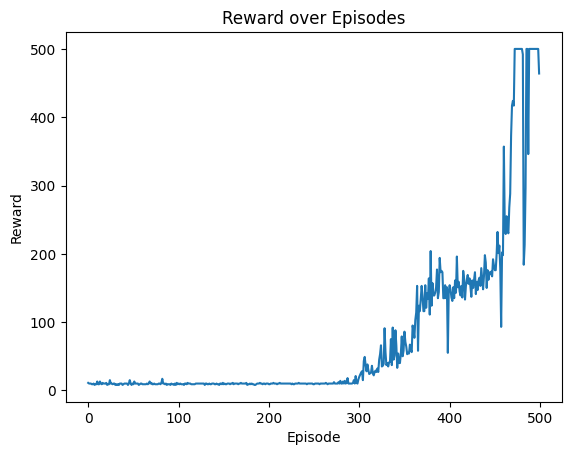

In [ ]:
# --- Plot the rewards ---
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward over Episodes")
plt.show()

## 4. Gameplay Visualization

To further demonstrate the performance of our trained agent, we record gameplay using Gym's rendering capabilities. The following code uses the `RecordVideo` wrapper to save a video of the agent playing an Atari game.


In [ ]:
# Create the environment for recording; adjust the environment name as needed.
# Wrap the environment to record video (save video to './video' folder)
env = RecordVideo(env, video_folder=f'{output_folder}/video', episode_trigger=lambda episode: True)

# Reset environment and run a single episode using either a random or the trained policy.
state = env.reset()
done = False
while not done:
    # For evaluation, you might want to use a near-greedy policy; here, we use random actions for demonstration.
    action = select_action(state, epsilon=0.05)

    state, reward, done, _ = env.step(action)

env.close()
print("Gameplay video saved in the ./video folder.")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Colab Notebooks/Deep Learning SoftUni/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Gameplay video saved in the ./video folder.


I decided to add **OpenCV** and record one of the best plays

In [ ]:
import cv2
import gym
import numpy as np

# Ensure your environment is created with render_mode set to 'rgb_array'
env = gym.make(ENV_NAME, render_mode='rgb_array')

# Record video using the trained policy (not random actions)
frames = []
# Here, we'll record one episode that demonstrates the learned behavior.
state = env.reset()
done = False

while not done:
    # Use the trained policy with a near-greedy setting for evaluation.
    action = select_action(state, epsilon=0.05)
    state, reward, done, _ = env.step(action)

    # Render returns a frame
    frame = env.render()

    # The frame may have an extra batch dimension, so process it:
    frame = np.array(frame)
    if len(frame.shape) > 3 and frame.shape[0] > 1:
        frame = frame[0]
    else:
        frame = np.squeeze(frame)

    frames.append(frame)

env.close()
print("Finished recording the episode.")

# Process the first frame to get video dimensions.
first_frame = frames[0]
if len(first_frame.shape) > 3 and first_frame.shape[0] > 1:
    first_frame = first_frame[0]
else:
    first_frame = np.squeeze(first_frame)

if len(first_frame.shape) != 3:
    raise ValueError("Frame shape after processing is not (height, width, channels). Got: {}".format(first_frame.shape))

height, width, channels = first_frame.shape

# Define the video writer using OpenCV.
output_video_path = f'{output_folder}/video/recorded_gameplay.avi'
video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'XVID'), 30, (width, height))

# Write each frame to the video file.
for frame in frames:
    # Process each frame similarly
    if len(frame.shape) > 3 and frame.shape[0] > 1:
        frame = frame[0]
    else:
        frame = np.squeeze(frame)
    # Convert frame from RGB to BGR as OpenCV expects BGR format.
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    video.write(frame_bgr)

video.release()
print(f"Combined gameplay video saved as {output_video_path}")


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Finished recording the episode.
Combined gameplay video saved as /content/drive/MyDrive/Colab Notebooks/Deep Learning SoftUni/video/recorded_gameplay.avi


## Recorded Gameplay Video

I cannot import the video and display it in the notebook, i cant even embed it after uploading to YouTube, so here is the link if you want to see the agent's gameplay performance:

https://youtu.be/lvPkzQDbN2E


## Improving Model Performance

1. **Increase the Number of Training Episodes:**  
   Increasing `MAX_EPISODES` to 1000 or even more will give the agent more opportunities to explore and learn a stable policy.

2. **Enhance the Network Architecture:**  
   Although CartPole is a simple environment, try increasing the number of neurons in each Dense layer.

3. Tune the Learning Rate:
 - Experiment with lowering the learning rate if you notice unstable training or high loss values.

4. Consider Advanced Techniques:
 - Implementing techniques such as Double DQN or Dueling DQN may help reduce overestimation bias and improve learning stability.

5. Monitor Training Loss:
 - It is also useful to plot the training loss over time. A steadily decreasing loss typically indicates that the network is learning effectively.

Next Steps

- Experiment with Different Hyperparameters:
 - Try adjusting EPSILON_DECAY, MAX_EPISODES, learning rate, and network architecture. Record the impact on the average episode rewards.

- Run More Evaluation Episodes:
 - When loading a pretrained model (or after training), run multiple evaluation episodes (using a near-greedy policy) and compute the average reward. A consistent average reward near 500 for CartPole-v1 indicates that the model has learned to balance the pole well.

- Visualize and Compare Results:
 - Plot the reward progression over episodes. If you make multiple runs with different settings, create a comparative plot to see which settings yield better performance.

In my case, I did hundreds of runs on 3 different machines and got the best one exported and uploaded to Google Drive, so this notebook is actually one of the best results I've gotten over these runs.

I find these results satisfying enough for proof of concept so I will not implement these optimizations for now (as time is running out as well), but I just had to mention them as improvement is possible and needed in real projects.

## My Rigs:

- Using Google Colab _(slowest option)_ with CPU as T4 GPU is limited and usually disconnects before finishing as I have ran out of free trial computation on it, so I used CPU and got about 10-12 hours training for 500 episodes.

- NVIDIA RTX 3060 - _(mid option)_ - I got average of 6-8 hours training time for 500 episodes.

- NVIDIA RTX 4090 - _(my best option)_ - About 3-4 hours training time for 500 episodes and twice as much for 1000 episodes.

_(With limited access to the best rig as this machine is located at work, so I had to use it only while at work, for the most part I was accessing my personal machine at home via **Parsec** remote access and running both the 4090 and 3060 at the same time as well as Google Colab and then when I get home, I continued experimenting on 3060 and colab. My machine was running 24/7 for a week for these results, and as I can see it was worth it.)_

## References

1. Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013). [Playing Atari with Deep Reinforcement Learning](https://www.arxiv.org/pdf/1312.5602). arXiv preprint arXiv:1312.5602.

2. Park, J., Kim, M., & Choi, J. (2021). [Learning Student-Friendly Teacher Networks for Knowledge Distillation](https://arxiv.org/abs/2102.07650). arXiv preprint arXiv:2102.07650.

3. van Hasselt, H., Guez, A., & Silver, D. (2015). [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461). arXiv preprint arXiv:1509.06461.

4. Wang, Z., Schaul, T., Hessel, M., van Hasselt, H., Lanctot, M., & Freitas, N. (2016). [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581). arXiv preprint arXiv:1511.06581.

5. Kingma, D. P., & Ba, J. (2014). [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980). arXiv preprint arXiv:1412.6980.